<center><h1><b><span style="color:blue">"HEP Python ecosystem example"</span></b></h1></center>

#### **"Thinking outside the box"**

Other groups and projects are working on other domain-specific areas towards the common goal of a modern, Pythonic and friendly analysis ecosystem for HEP. Let's play a bit with the `phasespace` and `zfit` packages from the [zfit project](https://github.com/zfit/).

&nbsp;<br><center><img src="images/logo_zfit.png" alt="zfit package logo" style="width: 200px;"/></center>

<center><h2><b><span style="color:green">Model building and fitting library based on TensorFlow</span></b></h2></center>

The `zfit` package is a model fitting library based on TensorFlow and optimised for simple and direct manipulation of probability density functions. The main focus is on the scalability, parallelisation and a Pythonic user friendly experience framework.

## **A HEP common usecase - simultaneoous fit to a signal decay and a control mode**

<div class="alert alert-info">

<b>Acknowledgements:</b>

This tutorial is largely based on code kindly provided by Jonas Eschle (University of Zurich).
It showcases the generation and fit of samples of $ B \to K^* \mu^+ \mu^-$ events,
including a simultaneous, and the subsequent determination of the signal significance.
</div>

### Unbinned maximum likelihood model fit to $B^0 \to \mu^+ \mu^- K^{*0}$

The fit will be done in three steps using the `zfit` package:
- a fit with the exponential to the right side to have a good starting value.
- a model composed of an exponential for the combinatorial bkg and a double Crystalball for the $B^0 \to \mu^+ \mu^- K^{*0}$ signal is built and fitted to the "rare" mode. This is hard to get right, as we have low statistics in the rare mode.
- To improve the fit, the same model with a few shared parameters is built for the resonant mode $B^0 \to J/\psi (\to \mu^+ \mu^-) K^{*0}$
  to improve the shape of the DoubleCB, as mostly the tails are tricky. They seem to be independent of q2, so we can share them.

### **0. Imports, settings, helper functions**

Let's start by importing
- Standard library modules
- Scikit-HEP packages
- `phasespace` and `zfit`

... this is what is meant by working with an ecosystem ;-)

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from particle.particle import literals as lp
from hepstats import hypotests

from phasespace import GenParticle

import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = "True"  # suppresses TensorFlow warnings
import zfit

/srv/conda/envs/notebook/lib/python3.7/site-packages/zfit/__init__.py:32: UserWarning: zfit has moved from TensorFlow 1.x to 2.x, which has some profound implications behind the scenes of zfit
    and minor ones on the user side. Be sure to read the upgrade guide (can be found in the README at the top)
     to have a seemless transition. If this is currently not doable (upgrading is highly recommended though)
     you can downgrade zfit to <0.4. Feel free to contact us in case of problems in order to fix them ASAP.
  you can downgrade zfit to <0.4. Feel free to contact us in case of problems in order to fix them ASAP.""")


**General settings:**

In [2]:
seed = 11  # a "good" seed
tf.random.set_seed(seed)
np.random.seed(seed)

B0_MASS = lp.B_0.mass
JPSI_MASS = lp.Jpsi_1S.mass
KSTARZ_MASS = lp.Kst_892_0.mass
KSTARZ_WIDTH = lp.Kst_892_0.width
PION_MASS = lp.pi_minus.mass
KAON_MASS = lp.K_plus.mass
MU_MASS = lp.mu_minus.mass

# Yields - feel free to change these to play around
n_sig_rare = 120
n_sig_reso = 4000
n_bkg_rare = 5000
n_bkg_reso = 3000

# Detector smearing of the particles 4-momenta (sigma of a Gaussian)
rare_smearing = 7
reso_smearing = 7

**Helper functions**

In [3]:
def invariant_mass(four_momenta):
    """Calculate the invariant mass given a four momenta with shape (n_events, 4) with px, py, pz, E."""
    momenta_squared = four_momenta ** 2
    return np.sqrt(momenta_squared[:, 3] - np.sum((momenta_squared[:, :3]), axis=-1))

In [4]:
# Since this is kinematically sampled from a fixed B mass, currently the reconstructed invariant B mass would only
# be a sharp peak. To include detector resolution effects and make it look more like real data/MC,
# the particles are smeared (similar to what RapidSim does).
def smear_momenta(four_momenta, smearing=10):
    """Smears the momenta (gaussian) with a width of `smearing`."""
    # The four_momenta are "eager_tensors", wrapped numpy arrays. 
    # We could convert them with `np.array(four_momenta)`
    return np.random.normal(loc=four_momenta, scale=smearing)

### **1. Phasespace generation of the rare signal**

In [5]:
# To generate the signal, we will sample from the phasespace of the decay and apply some ad-hoc smearing.
# Using the phasespace package, a decay chain has to be sticked together with the different particles.
# While this is simple to do for non-resonant particles with a fixed mass, since it is only a number,
# phasespace allows also for (arbitrary) resonance shapes of the mass. Therefor, instead of a constant number,
# a function that samples from the resonance can be provided, whereby min_mass, max_mass specify the kinematically
# allowed boundaries for the mass. This is best illustrated with the example below

# K* is resonant, we define here the sampling of the mass.
# Either zfit PDFs or TensorFlow Probability distributions (or anything using TensorFlow, also arbitrary
# Python functions wrappet with `tf.py_function`, can be used). White TensorFlow Probability offers many usefule
# distributions, they often have support from -inf to inf, while zfit PDFs offer the possitility to sample only
# within certain limits.


def kstar_mass(min_mass, max_mass, n_events):
    # make sure everything is float64
    min_mass = tf.cast(min_mass, tf.float64)
    max_mass = tf.cast(max_mass, tf.float64)
    kstar_width_cast = tf.cast(KSTARZ_WIDTH, tf.float64)
    kstar_mass_cast = tf.cast(KSTARZ_MASS, dtype=tf.float64)

    # To produce n_events samples, we can e.g. broadcast the K* mass (currently a scalar)
    # to have the right shape (n_events,). But there are many ways, also see TensorFlow Probability Distributions
    kstar_mass = tf.broadcast_to(kstar_mass_cast, shape=(n_events,))
    if KSTARZ_WIDTH > 0:
        kstar_mass = tfp.distributions.TruncatedNormal(loc=kstar_mass,
                                                       scale=kstar_width_cast,
                                                       low=min_mass,
                                                       high=max_mass).sample()
    return kstar_mass


# create the K* and also set its children.
kstar = GenParticle('K*0', mass=kstar_mass).set_children(GenParticle('K+', mass=KAON_MASS),
                                                         GenParticle('pi-', mass=PION_MASS))
bz = GenParticle('B0', B0_MASS).set_children(kstar,
                                             GenParticle('mu+', mass=MU_MASS),
                                             GenParticle('mu-', mass=MU_MASS))

# `generate` returns the weights of the event and a dict which contains the 4-momenta of the particles
# as {particle_name: EagerTensor of shape (n_events, 4)}, where an EagerTensor is basically a wrapped numpy array.
# and the particle_name is e.g. 'K+', 'K*0', the name that has been used above.
weights, particles = bz.generate(n_sig_rare)
weights = weights / np.average(weights)


# Since this is kinematically sampled from a fixed B mass, currently the reconstructed invariant B mass would only
# be a sharp peak. To include detector resolution effects and make it look more like real data/MC, the particles are smeared.
smeared_momenta = {}
daugther_particles = ['K+', 'pi-', 'mu+', 'mu-']
for particle in daugther_particles:
    smeared_momenta[particle] = smear_momenta(particles[particle], smearing=rare_smearing)

# reconstruct the mother particles using the smeared daughters
smeared_momenta['K*0'] = smeared_momenta['K+'] + smeared_momenta['pi-']
smeared_momenta['Jpsi'] = smeared_momenta['mu+'] + smeared_momenta['mu-']
smeared_momenta['B0'] = smeared_momenta['K*0'] + smeared_momenta['Jpsi']

b_mass_rare = invariant_mass(smeared_momenta['B0'])
q2 = invariant_mass(smeared_momenta['Jpsi']) ** 2

**Visualise the spectrum:**

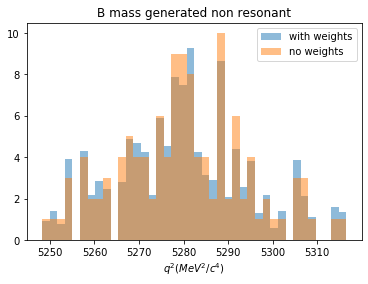

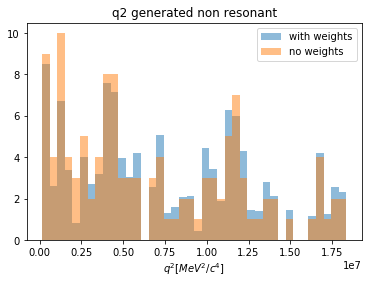

In [6]:
# to be used later
xlabel_bmass = 'm($K^+ \pi^- \mu^+ \mu^-$) [MeV/c^2]'

# plot the b mass with the weights. It is basically the same as without weights.
plt.figure()
plt.title("B mass generated non resonant")
plt.hist(b_mass_rare, weights=weights, alpha=0.5, bins=40, label="with weights")
plt.hist(b_mass_rare, bins=40, alpha=0.5, label="no weights")
plt.xlabel('$q^2 (MeV^2/c^4)$')
plt.legend()

plt.figure()
plt.title("q2 generated non resonant")
plt.hist(q2, weights=weights, alpha=0.5, bins=40, label="with weights")
plt.hist(q2, bins=40, alpha=0.5, label="no weights")
plt.xlabel('$q^2 [MeV^2/c^4]$')
plt.legend()

### **2. Fit to the rare signal**

The fit will be done in three steps using the zfit package:
- a fit with the exponential to the right side to have a good
  starting value.
- a model composed of an exponential for the combinatorial bkg and a double Crystalball for
  the signal is built and fitted to the "rare" mode. This is hard to get right, as we have low
  statistics in the rare mode.
- To improve the fit, the same model with a few shared parameters is built for the resonant mode
  to improve the shape of the DoubleCB, as moslty the tails are tricky. They seem to be independent
  of q2, so we can share them

#### If the fit does not converge

Finding the minimum given some parameters is in general not a simple problem. Two major reasons this does
not work well are the initial values and the step_size that are too far off or too large/small. The latter
should be around the uncertainty of the parameter (once the fit will be converged). More information can be
found here: https://github.com/zfit/zfit/wiki/FAQ#fitting-and-minimization

**2.a Fit to the right-hand sideband**

In [7]:
# Firstly, the observable and its range is defined
upper_limit = 5600
obs = zfit.Space('Bmass', (5000, upper_limit))  # for whole range
obs_bkg = zfit.Space('Bmass', (5400, upper_limit))  # to pre-fit the exponential

# Parameters are specified:  (name (unique), initial, lower, upper) whereas lower, upper are optional
lambda_rare = zfit.Parameter('lambda_rare', -0.002, -0.01, -0.0001, step_size=0.0005)  # floating, also without limits
comb_bkg_rare = zfit.pdf.Exponential(lambda_rare, obs=obs)

# Create some bkg data
comb_bkg_rare_sample = comb_bkg_rare.sample(n=n_bkg_rare)  # sampled within the limits of `obs`

# To improve the fit, the rightside can first be fitted to the combinatorial background in order to get
# a good initial value
right_tale_data_rare = zfit.Data.from_numpy(obs=obs_bkg, array=comb_bkg_rare_sample.value())

# Set the value of lambda to something different than we sampled from (for the fit afterwards)
lambda_rare.set_value(-0.003)

# The normalisation range is temporarily set to the right side only
with comb_bkg_rare.set_norm_range(obs_bkg):
    right_tale_loss = zfit.loss.UnbinnedNLL(comb_bkg_rare, right_tale_data_rare)
    minimizer = zfit.minimize.Minuit(verbosity=7, use_minuit_grad=True)
    result_right_tale = minimizer.minimize(right_tale_loss)

------------------------------------------------------------------
| FCN = 5789                    |      Ncalls=13 (13 total)      |
| EDM = 0.000287 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


**2.b Fit to the full spectrum**

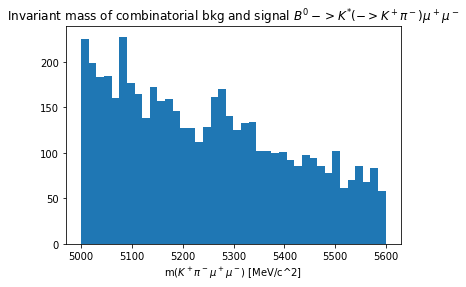

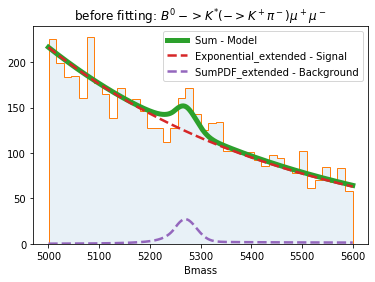

------------------------------------------------------------------
| FCN = -6130                   |    Ncalls=1101 (1101 total)    |
| EDM = 0.000374 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


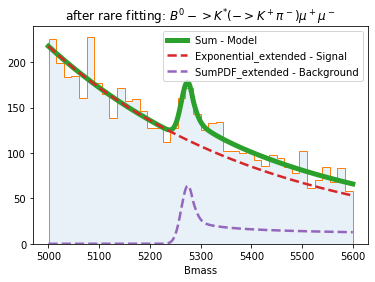

OrderedDict([(<zfit.Parameter 'rare_bkg_yield' floating=True value=4656>,
              {'value': 4655.511050035808}),
             (<zfit.Parameter 'rare_sig_yield' floating=True value=455.4>,
              {'value': 455.3940007976625}),
             (<zfit.Parameter 'lambda_rare' floating=True value=-0.00235>,
              {'value': -0.0023502898784308326}),
             (<zfit.Parameter 'frac dcb' floating=True value=0.9>,
              {'value': 0.8999708194751244}),
             (<zfit.Parameter 'alpha left rare' floating=True value=-0.6734>,
              {'value': -0.6733707752581415}),
             (<zfit.Parameter 'mu' floating=True value=5275>,
              {'value': 5274.850471751084}),
             (<zfit.Parameter 'n left rare' floating=True value=0.2277>,
              {'value': 0.22772018472953848}),
             (<zfit.Parameter 'sigma' floating=True value=12.89>,
              {'value': 12.89384519822316}),
             (<zfit.Parameter 'alpha right rare' floating=Tr

In [8]:
# Create the data for the rare fit
rare_data_np = np.concatenate([b_mass_rare, comb_bkg_rare_sample[:, 0]], axis=0)
rare_weights_np = np.concatenate([weights, np.ones_like(comb_bkg_rare_sample[:, 0])], axis=0)
# TODO: we could do some data preprocessing here (e.g. apply a cut to q2, which we actually
# need to have "no Jpsi" in there). This can be done with pandas and then loaded into zfit

rare_data = zfit.Data.from_numpy(obs=obs, array=rare_data_np, weights=rare_weights_np)
# Data can also be loaded from ROOT
# right_tale_data_rare = zfit.Data.from_root(...)

# ...or to/from a pandas DataFrame. Either convert the `zfit.Data` to a pandas DF
# right_tale_data_rare_df = right_tale_data_rare.to_pandas()
# .... or create it from scratch
# right_tale_data_rare_df = pd.DataFrame(data=rare_data_np, columns=obs_bkg.obs)
# Then we can directly load it
# right_tale_data_rare = zfit.Data.from_pandas(df=right_tale_data_rare_df, obs=obs_bkg)

# (maybe remove plot, just for data visualisation example?)
plt.figure()
plt.title("Invariant mass of combinatorial bkg and signal $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$")
plt.hist(rare_data_np, weights=rare_weights_np, bins=40)
plt.xlabel(xlabel_bmass)

# Create the model to fit to the rare mode

# Parameters for the model
mu = zfit.Parameter('mu', 5270, 5200, 5350, step_size=3)
sigma = zfit.Parameter('sigma', 22, 1, 100, step_size=0.1)

# A double crystalball, a sum of two Crystal Ball functions will be used
alphal_rare = zfit.Parameter('alpha left rare', -0.3, -5, 0)
nl_rare = zfit.Parameter('n left rare', 0.3, 0, 10)
alphar_rare = zfit.Parameter('alpha right rare', 1, 0, 5)
nr_rare = zfit.Parameter('n right rare', 2.8, 0, 10)
frac_dcb_rare = zfit.Parameter('frac dcb', 0.3, 0.1, 0.9)

left_cb_rare = zfit.pdf.CrystalBall(obs=obs,
                                    mu=mu, sigma=sigma,
                                    alpha=alphal_rare, n=nl_rare,
                                    )
right_cb_rare = zfit.pdf.CrystalBall(obs=obs,
                                     mu=mu, sigma=sigma,
                                     alpha=alphar_rare, n=nr_rare,
                                     )
signal_rare = zfit.pdf.SumPDF([left_cb_rare, right_cb_rare], fracs=frac_dcb_rare)


# Create the yields and the extended pdfs
rare_sig_yield = zfit.Parameter('rare_sig_yield', n_sig_rare + 30,
                                step_size=3)  # step size: default is small, use appropriate
rare_bkg_yield = zfit.Parameter('rare_bkg_yield', n_bkg_rare - 40, step_size=1)
# Create extended PDFs
extended_sig_rare = signal_rare.create_extended(rare_sig_yield)
extended_bkg_rare = comb_bkg_rare.create_extended(rare_bkg_yield)

# The final model is the combination of the signal and backgrond pdf
model_rare = zfit.pdf.SumPDF([extended_bkg_rare, extended_sig_rare])


# Different models could be used here. A more simple model, such as a Gaussian...
# signal_rare = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)

# ...or even a completely custom PDF. Explained also here: https://zfit.readthedocs.io/en/latest/intro/model.html#custom-pdf
# from zfit import z  # backend, can also use TensorFlow directly
#
# class MySignal(zfit.ZPDF):
#     _N_OBS = 1
#     _PARAMS = ['mean', 'width']
#    
#     # Implement the shape (unnormalized) of your pdf. If the analytical integral is known, it can be
#     # registered later on.
#     def _unnormalized_pdf(self, x):
#         x = z.unstack(x)  # could be higher dimensional
#         mean = self.params['mean']
#         width = self.params['width']
#         return z.exp((x - mean) ** 2 / (2 * width ** 2))  # Gaussian, unnormalized
#
#
# signal_rare = MySignal(mean=mu, width=sigma, obs=obs)


# In order to plot our model, a helper function is created
def plot_pdf_data(data, model, title, n_bins=40):
    linewidth = 2.5
    space = data.data_range
    plot_scaling = data.nevents / n_bins * space.area()
    lower, upper = space.limit1d
    x = np.linspace(lower, upper, 1000)

    plt.figure()
    plt.title(title)

    # plot the data
    data_np = data[:, 0]
    plt.hist(data_np,
             # color=color,
             bins=n_bins, histtype="stepfilled", alpha=0.1)
    plt.hist(data_np,
             # color=color,
             bins=n_bins, histtype="step")
    # plot the pdfs
    y = zfit.run(model.pdf(x))
    y_sig = zfit.run(model.pdfs[0].pdf(x) * model.fracs[0])# notice the frac!
    y_bkg = zfit.run(model.pdfs[1].pdf(x) * model.fracs[1])  # notice the frac!

    plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth * 2)
    plt.plot(x, y_sig * plot_scaling, '--', label=f"{model.pdfs[0].name} - Signal", linewidth=linewidth)
    plt.plot(x, y_bkg * plot_scaling, '--', label=f"{model.pdfs[1].name} - Background", linewidth=linewidth)
    plt.xlabel(space.obs[0])
    plt.legend()
    

plot_pdf_data(data=rare_data, model=model_rare, title='before fitting: $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plt.show()

# As a next step, the loss is created: the minimum of it defines the solution to the problem
ext_rare_nll = zfit.loss.ExtendedUnbinnedNLL(model_rare, rare_data)

# The minimization uses by default all floating parameters (that the model(s) used in the loss depend on)
# but they can also be explicitly specified as an argument to `minimize`.
result_rare = minimizer.minimize(ext_rare_nll)

# The parameter values are set automatically to the value found at the minimum.
plot_pdf_data(data=rare_data, model=model_rare, title='after rare fitting: $B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plt.show()
# The information about the minimization and the result of it are stored in the
# FitResult that is returned. It contains e.g. information about the parameters
pprint(result_rare.params)

# ...and more:
print(f"The fit converged: {result_rare.converged}, the minimum is {result_rare.fmin}")

# Following are error estimations. They return the result and also add it into the `params` attribute.
# Unfortunately, hesse is currently not yet supported with weights.
# result_rare.hesse()  # error calculation using the inverse hessian approximation
# result_rare.error()  # error calculation using minos, this takes all parameters (expensive)
result_rare.error([rare_sig_yield, mu])  # just for specific parameters
pprint(result_rare.params)

# the params can be accesssed using the parameter objects (not their names!)
mu_rare_fit = result_rare.params[mu]
# they contain information about the result such as value etc
print(f"Mu value of rare fit: {mu_rare_fit['value']} "
      f"+ {mu_rare_fit['minuit_minos']['upper']} "
      f"- {mu_rare_fit['minuit_minos']['upper']}"
      # f" (symmetric Hesse error: {mu_rare_fit['minuit_hesse']['error']})"
      )

### **3. Phasespace generation of the resonant decay**

Since the previous fit, e.g. the tail, was not great due to the lack of statistics, we can also fit the resonant mode simultaneously and share certain parameters.

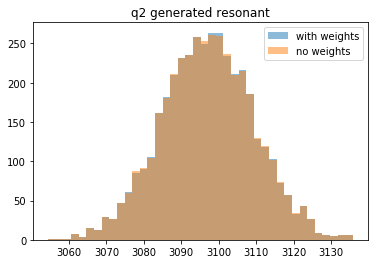

In [9]:
# Create the resonant decay. This is basically the same as above, we simply add an intermediate Jpsi.
bz = GenParticle('B0', B0_MASS).set_children(kstar,
                                             GenParticle('Jpsi', mass=JPSI_MASS).set_children(
                                                 GenParticle('mu+', mass=MU_MASS),
                                                 GenParticle('mu-', mass=MU_MASS)
                                             ))

weights_reso, particles_reso = bz.generate(n_sig_reso)
weights_reso /= np.average(weights_reso)

smeared_momenta_reso = {}
daugther_particles_reso = ['K+', 'pi-', 'mu+', 'mu-']
for particle in daugther_particles_reso:
    smeared_momenta_reso[particle] = smear_momenta(particles_reso[particle], smearing=reso_smearing)

smeared_momenta_reso['K*0'] = smeared_momenta_reso['K+'] + smeared_momenta_reso['pi-']
smeared_momenta_reso['Jpsi'] = smeared_momenta_reso['mu+'] + smeared_momenta_reso['mu-']
smeared_momenta_reso['B0'] = smeared_momenta_reso['K*0'] + smeared_momenta_reso['Jpsi']

b_mass_reso = invariant_mass(smeared_momenta_reso['B0'])
q2_reso = invariant_mass(smeared_momenta_reso['Jpsi'])

# plot the q2
plt.figure()
plt.title("q2 generated resonant")
plt.hist(q2_reso, weights=weights_reso, alpha=0.5, bins=40, label="with weights")
plt.hist(q2_reso, bins=40, alpha=0.5, label="no weights")
plt.legend()

# ------------------------------------------------
# COMBINATORIAL BACKGROUND RESO
# ------------------------------------------------

lambda_reso = zfit.Parameter('lambda_reso', -0.002, -0.01, 0.0001)  # floating, also without limits
comb_bkg_reso_pdf = zfit.pdf.Exponential(lambda_reso, obs=obs)

# Create some more bkg data
comb_bkg_reso_sample = comb_bkg_reso_pdf.sample(n=n_bkg_reso)  # sampled within the limits of `obs`

# Set the value of lambda to smth different then we sampled from (for the fit afterwards)
lambda_reso.set_value(-0.01)

reso_data_np = np.concatenate([b_mass_reso, comb_bkg_reso_sample[:, 0]], axis=0)
reso_weights_np = np.concatenate([weights_reso, np.ones_like(comb_bkg_reso_sample[:, 0])], axis=0)

reso_data = zfit.Data.from_numpy(obs=obs, array=reso_data_np)

**Visualise the spectrum:**

(array([ 138.        ,  116.        ,  109.        ,  107.        ,
         100.        ,  119.        ,  111.        ,  107.        ,
          79.        ,  108.        ,   91.        ,  108.        ,
          93.        ,   76.        ,   88.        ,   71.94651297,
         200.33279678,  900.28704043, 1668.60514375, 1208.4476243 ,
         345.76075897,  105.62012279,   71.        ,   63.        ,
          58.        ,   61.        ,   67.        ,   46.        ,
          63.        ,   55.        ,   55.        ,   50.        ,
          49.        ,   52.        ,   37.        ,   50.        ,
          50.        ,   43.        ,   47.        ,   32.        ]),
 array([5000.36171988, 5015.33677944, 5030.311839  , 5045.28689856,
        5060.26195812, 5075.23701769, 5090.21207725, 5105.18713681,
        5120.16219637, 5135.13725593, 5150.11231549, 5165.08737505,
        5180.06243462, 5195.03749418, 5210.01255374, 5224.9876133 ,
        5239.96267286, 5254.93773242, 5269.912

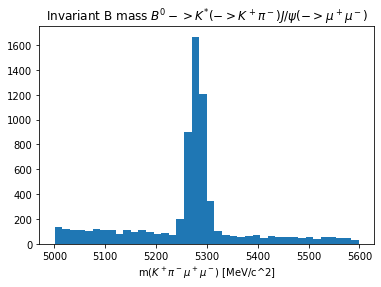

In [10]:
# (maybe remove plot, just for data visualization example?)
plt.figure()
plt.title("Invariant B mass $B^0 -> K^{*} (-> K^+ \pi^-) J/\psi (-> \mu^+ \mu^-)$")
plt.xlabel(xlabel_bmass)
plt.hist(reso_data_np, weights=reso_weights_np, bins=40)

In [11]:
# ------------------------------------------------
# RESONANT MODEL
# ------------------------------------------------

# create the model to fit

# we can share parameters directly or create composed parameters. Here we have a
# parameter that scales the sigma from the rare fit

sigma_scaling = zfit.Parameter('sigma_scaling', 0.9, 0.5, 10, step_size=0.1)


def sigma_scaled_fn():
    return sigma * sigma_scaling  # this can be an arbitrary function


sigma_scaled = zfit.ComposedParameter('sigma scaled', sigma_scaled_fn,
                                      dependents=sigma  # the objects used inside the function
                                      )

# Insead of sharing, free parameters could be used. This would though defy the purpose of the
# simultaneous fit here. If we know that some can't be shared though (e.g. the tails between a 
# muon and electron modes), only certain parameters can be shared.
# alphal_reso = zfit.Parameter('alpha left reso', -0.7, -5, 0)
# nl_reso = zfit.Parameter('n left reso', 0.4, 0, 10)
# alphar_reso = zfit.Parameter('alpha right reso', 1, 0, 5)
# nr_reso = zfit.Parameter('n right reso', 1.8, 0, 10)

alphal_reso = alphal_rare
nl_reso = nl_rare
alphar_reso = alphal_rare
nr_reso = nr_rare

# frac_dcb_reso = zfit.Parameter('frac dcb_reso', 0.5, 0.01, 0.99)
frac_dcb_reso = frac_dcb_rare
left_cb_reso = zfit.pdf.CrystalBall(obs=obs,
                                    mu=mu, sigma=sigma_scaled,
                                    alpha=alphal_reso, n=nl_reso,
                                    )
right_cb_reso = zfit.pdf.CrystalBall(obs=obs,
                                     mu=mu, sigma=sigma_scaled,
                                     alpha=alphar_reso, n=nr_reso,
                                     )
signal_reso = zfit.pdf.SumPDF([left_cb_reso, right_cb_reso], fracs=frac_dcb_reso)

# Again, also a simpler (or custom) shape could be used
# signal_reso = zfit.pdf.Gauss(mu=mu,  # using the same mu as above means it's shared
#                              sigma=sigma_scaled, obs=obs)

reso_sig_yield = zfit.Parameter('reso_sig_yield', n_sig_reso - 100, 0, n_sig_reso * 3,
                                step_size=1)  # step size: default is small, use appropriate
reso_bkg_yield = zfit.Parameter('reso_bkg_yield', n_bkg_reso + 70, 0, n_bkg_reso * 3, step_size=1)

# Create the extended models
extended_sig_reso = signal_reso.create_extended(reso_sig_yield)
extended_bkg_reso = comb_bkg_reso_pdf.create_extended(reso_bkg_yield)
model_reso = zfit.pdf.SumPDF([extended_bkg_reso, extended_sig_reso])

### **4. Simultaneous fit**

- Built the simultaneous loss function.
- Run the simultaneous fit.
- Print and plot the fit results.

In [12]:
# Constraints could also be added to the loss, we don't have a good use-case here, so we leave them away.
# They usually resemble other measurements of a parameter with an uncertainty in the same order of
# magnitude as the sensitivity of our fit. Too strong constraint parameters can be though of as constants,
# too loose do not add anything.
# constraint = zfit.constraint.GaussianConstraint(mu, observation=5279, uncertainty=50)
# ext_reso_nll = zfit.loss.ExtendedUnbinnedNLL(model_reso, reso_data, constraints=constraint)

ext_reso_nll = zfit.loss.ExtendedUnbinnedNLL(model_reso, reso_data)

# to create a simultaneous loss, the individual losses are added
simultaneous_loss = ext_reso_nll + ext_rare_nll

result_simult = minimizer.minimize(simultaneous_loss)

/srv/conda/envs/notebook/lib/python3.7/site-packages/zfit/core/loss.py:100: UserWarning: The fit_range argument is depreceated and will maybe removed in future releases. It is preferred to define the range in the space when creating the data and the model.
  warnings.warn("The fit_range argument is depreceated and will maybe removed in future releases. "


------------------------------------------------------------------
| FCN = -2.225E+04              |    Ncalls=1825 (1825 total)    |
| EDM = 0.000735 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


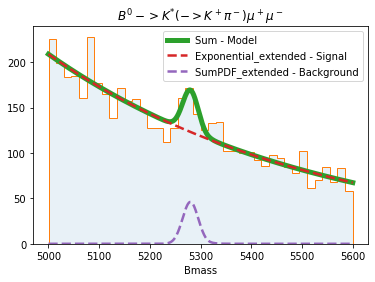

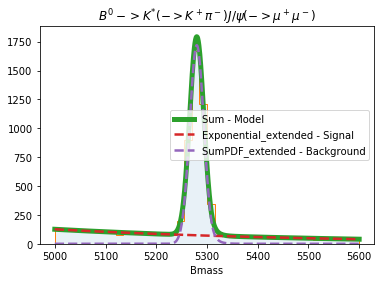

OrderedDict([(<zfit.Parameter 'mu' floating=True value=5280>,
              MError(name='mu', is_valid=False, lower=-0.250241011916965, upper=3.09258350813343, lower_valid=True, upper_valid=False, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=3569, min=5279.912325268547)),
             (<zfit.Parameter 'rare_sig_yield' floating=True value=118.5>,
              MError(name='rare_sig_yield', is_valid=True, lower=-24.93018863894388, upper=25.733852467449573, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=917, min=119.38883784954703)),
             (<zfit.Parameter 'reso_sig_yield' floating=True value=4039>,
              MError(name='reso_sig_yield', is_valid=False, lower=-1754.8739740205942, upper=1754.8739740205942, lower_valid=False, upper_valid=False, at_lower_limit=F

In [13]:
plot_pdf_data(data=rare_data, model=model_rare, title='$B^0 -> K^{*} (-> K^+ \pi^-) \mu^+ \mu^-$')
plot_pdf_data(data=reso_data, model=model_reso, title='$B^0 -> K^{*} (-> K^+ \pi^-) J/\psi (-> \mu^+ \mu^-)$')
plt.show()

# Hesse is not yet supported with weights
# result_simult.hesse()  # error calculation using hesse
errors = result_simult.error([mu, rare_sig_yield, reso_sig_yield])  # error calculation using minos, just for a few
# parameters as it is quite expensive
pprint(errors)

### **5. Wrapping up - determination of the signal significance**

Going beyond the fits one is often interested in obtaining limits or calculate signal significances.
These statistical procedures usually perform multiple fits with certain parameters fixed.

For this purpose, the `bhepstats` library can be used. It is built on top of the same interface that `zfit`
uses and therefore integrates well together. Models built and fits done in `zfit` will direclty work with `hepstats`.

In [14]:
# TODO: maybe expand on discoveries and p-values etc? Not sure how it best fits into the overall
# picture of the tutorial, you may have more on statistics somewhere else?

# using hepstats
from hepstats.hypotests import Discovery
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.parameters import POI

calculator = AsymptoticCalculator(simultaneous_loss, minimizer)
poinull = POI(rare_sig_yield, 0)
discovery_test = Discovery(calculator, poinull)
pnull, significance = discovery_test.result()
print(f'pnull: {pnull} with significance {significance}')

Get fit best values!
------------------------------------------------------------------
| FCN = -2.225E+04              |     Ncalls=251 (251 total)     |
| EDM = 1.07E-05 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

p_value for the Null hypothesis = 2.151731048893879e-07
Significance (in units of sigma) = 5.055019759917902
pnull: 2.151731048893879e-07 with significance 5.055019759917902


&nbsp;
## **Final remarks**

<div class="alert alert-info">

<b>Scikit-HEP &amp; the community:</b>

The ecosystem that has been presented in these tutorial notebooks is already advanced enough to perform analysis in it. All these packages, including zfit, are written and maintained by other physicists or scientists in general. As any other library, these packages are neither perfect (bug free) nor do they have all the features that you may want (developments are often not done after several years, after all). They are however built for simple contributions: if there are missing features or bugs, please report or directly contribute them yourself and become part of the ecosystem!
</div>